C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 96, 128)             │           3,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 32, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.4749 - loss: 1.0312 - val_accuracy: 0.7368 - val_loss: 0.6865
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7390 - loss: 0.7037 - val_accuracy: 0.8070 - val_loss: 0.4649
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8448 - loss: 0.4610 - val_accuracy: 0.9825 - val_loss: 0.2604
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9580 - loss: 0.2776 - val_accuracy: 0.9912 - val_loss: 0.0876
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9954 - loss: 0.1271 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9925 - loss: 0.0592 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9990 - loss: 0.0244 - val_accuracy: 0.9825 - val_loss: 0.0675

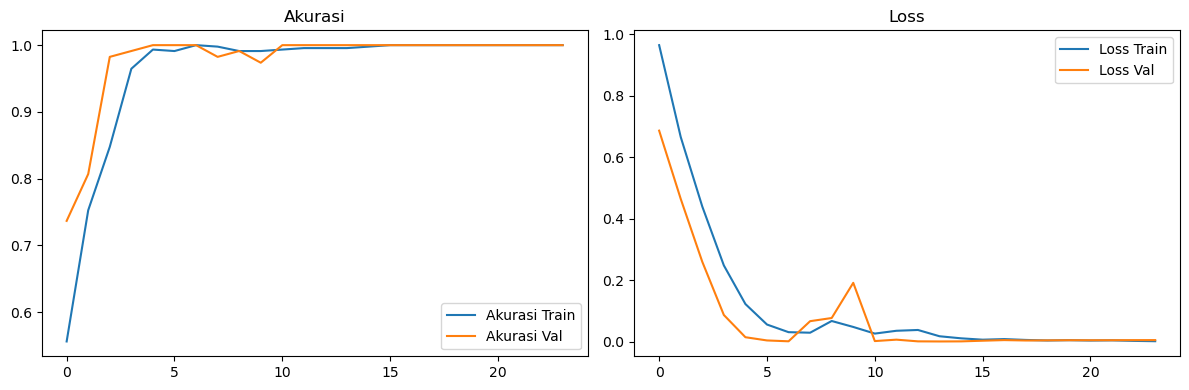

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
=== Classification Report ===
              precision    recall  f1-score   support

        diri       1.00      1.00      1.00        48
       duduk       1.00      1.00      1.00        46
       tidur       1.00      1.00      1.00        47

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



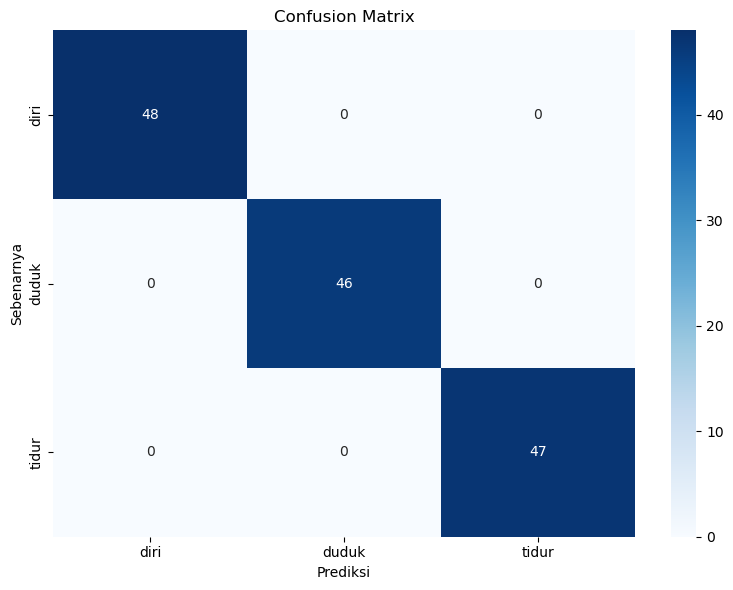

In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

from imblearn.over_sampling import SMOTE
from scipy.stats import mode

import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

# --- 1. Load data ---
df = pd.read_csv('data_3aktv.csv')

# --- 2. Tidak menggunakan magnitudo ---
features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# --- 3. Label Encoding ---
label_encoder = LabelEncoder()
df['encoded_activity'] = label_encoder.fit_transform(df['activity'])

X = df[features].values
y_encoded = df['encoded_activity'].values

# --- 4. Sliding Window ---
def create_windows(X, y, window_size=100, step=50):
    Xs, ys = [], []
    for start in range(0, len(X) - window_size + 1, step):
        end = start + window_size
        Xs.append(X[start:end])
        window_labels = y[start:end]
        counts = np.bincount(window_labels)
        ys.append(np.argmax(counts))
    return np.array(Xs), np.array(ys)


X_windows, y_windows = create_windows(X, y_encoded)

# --- 5. Split data sebelum normalisasi dan balancing ---
X_train, X_test, y_train, y_test = train_test_split(
    X_windows, y_windows, test_size=0.2, stratify=y_windows, random_state=42
)

# --- 6. Normalisasi ---
scaler = StandardScaler()

# reshape ke 2D untuk fit scaler
X_train_shape = X_train.shape
X_train_2d = X_train.reshape(-1, X_train_shape[2])
X_train_2d = scaler.fit_transform(X_train_2d)
X_train = X_train_2d.reshape(X_train_shape)

X_test_shape = X_test.shape
X_test_2d = X_test.reshape(-1, X_test_shape[2])
X_test_2d = scaler.transform(X_test_2d)
X_test = X_test_2d.reshape(X_test_shape)

# --- 7. SMOTE pada data train ---
X_train_flat = X_train.reshape((X_train.shape[0], -1))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape((-1, X_train_shape[1], X_train_shape[2]))

# --- 8. One-hot encoding label ---
num_classes = len(np.unique(y_train_resampled))
y_train_cat = to_categorical(y_train_resampled, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# --- 9. Class weights (optional, bisa dicoba) ---
# Kalau sudah SMOTE, class biasanya balance, bisa diabaikan atau dipakai untuk percobaan
# class_weights_array = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train_resampled),
#     y=y_train_resampled
# )
# class_weights = dict(enumerate(class_weights_array))

# --- 10. Definisikan Attention Layer ---
#class AttentionLayer(Layer):
#    def __init__(self, **kwargs):
#        super(AttentionLayer, self).__init__(**kwargs)

#    def build(self, input_shape):
#        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
#                                 initializer='random_normal', trainable=True)
#        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
#                                 initializer='zeros', trainable=True)
#        super(AttentionLayer, self).build(input_shape)

#    def call(self, inputs):
#        e = K.tanh(K.dot(inputs, self.W) + self.b)
#        a = K.softmax(e, axis=1)
#        output = K.sum(inputs * a, axis=1)
#        return output

# --- 11. Buat model CNN-LSTM dengan Attention ---
model = Sequential()
model.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))  
#model.add(AttentionLayer())
#model.add(Dropout(0.5))  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

# --- 12. Callbacks untuk training ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

# --- 13. Training ---
history = model.fit(
    X_train_resampled, y_train_cat,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# --- 14. Visualisasi training ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Train')
plt.plot(history.history['val_accuracy'], label='Akurasi Val')
plt.title('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label='Loss Val')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- 15. Evaluasi model ---
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("=== Classification Report ===")
print(classification_report(y_true, y_pred_class, target_names=label_encoder.classes_))

# --- 16. Confusion Matrix ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Prediksi")
plt.ylabel("Sebenarnya")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [57]:
print("Label Classes:", label_encoder.classes_)
print("Encoded Labels:", np.unique(y_encoded))


Label Classes: ['diri' 'duduk' 'jatuh' 'tidur']
Encoded Labels: [0 1 2 3]


In [59]:
# Simpan label encoder
import joblib
joblib.dump(label_encoder, 'label_encoder_new_4act.pkl')

['label_encoder_new_4act.pkl']

In [61]:
# Simpan model CNN-LSTM dengan attention
model.save("model_cnn_lstm_attention_new_4act.h5")
print("✅ Model disimpan ke model_cnn_lstm_attention_6act.h5")


✅ Model disimpan ke model_cnn_lstm_attention_6act.h5
